A corriger dans le process etl
- format datime : soit formart UTC soit format ns
- renommer les deux colonnes en df_transport = df_transport.rename(columns={'datetime_rounded': 'timestamp_rounded'})

In [77]:
import pandas as pd
import requests
import json
import os
import io
from dotenv import load_dotenv
import logging
from sqlalchemy import create_engine, text
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    f1_score,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

load_dotenv()

True

In [11]:
db_url = os.getenv("DATABASE_URL")

In [12]:
engine = create_engine(
    db_url,
    pool_pre_ping=True,
)

with engine.connect() as conn:
    result_transport = conn.execute(text("SELECT * FROM stg_transport_archive"))
    transport_data = result_transport.mappings().all()  # liste de dictionnaires

    result_weather = conn.execute(text("SELECT * FROM stg_weather_archive"))
    weather_data = result_weather.mappings().all()  # liste de dictionnaires

    

In [13]:
"""BASE_DIR = os.getcwd() 

DATA_DIR = os.path.join(BASE_DIR, "..","data")
json_path = os.path.join(DATA_DIR, "transport_koda_one_bus_3_days.json")
#json_path = os.path.join(DATA_DIR, "transport_koda_one_bus_any_days.json")

if not os.path.exists(json_path):
    print(f"Dossier actuel de recherche : {BASE_DIR}")
    raise FileNotFoundError(f"Le fichier {json_path} est introuvable.")

with open(json_path, 'r', encoding='utf-8') as f:
    transport_data = json.load(f)"""

'BASE_DIR = os.getcwd() \n\nDATA_DIR = os.path.join(BASE_DIR, "..","data")\njson_path = os.path.join(DATA_DIR, "transport_koda_one_bus_3_days.json")\n#json_path = os.path.join(DATA_DIR, "transport_koda_one_bus_any_days.json")\n\nif not os.path.exists(json_path):\n    print(f"Dossier actuel de recherche : {BASE_DIR}")\n    raise FileNotFoundError(f"Le fichier {json_path} est introuvable.")\n\nwith open(json_path, \'r\', encoding=\'utf-8\') as f:\n    transport_data = json.load(f)'

In [78]:
df_transport = pd.DataFrame(transport_data)
df_transport.describe()

,arrival_delay,departure_delay,direction_id,hour,id,stop_sequence,timestamp,timestamp_rounded
count,288.000000,288.000000,288.00000,288.000000,288.000000,288.000000,2.880000e+02,288
mean,81.284722,88.993056,0.50000,14.649306,721.500000,18.500000,1.742091e+09,2025-03-16 02:08:57.500000
min,-245.000000,-245.000000,0.00000,0.000000,578.000000,1.000000,1.741987e+09,2025-03-14 21:00:00
25%,0.000000,0.000000,0.00000,12.000000,649.750000,9.750000,1.742051e+09,2025-03-15 15:00:00
50%,57.500000,66.000000,0.50000,15.000000,721.500000,18.500000,1.742078e+09,2025-03-15 22:30:00
75%,172.250000,177.250000,1.00000,19.000000,793.250000,27.250000,1.742135e+09,2025-03-16 14:15:00
max,455.000000,471.000000,1.00000,23.000000,865.000000,36.000000,1.742165e+09,2025-03-16 23:00:00
std,119.356706,120.290705,0.50087,5.158660,83.282651,10.406377,4.816933e+04,NaN


In [99]:
df_weather = pd.DataFrame(weather_data)
df_weather.sample(20)
df_weather.describe()

,cloud_cover,day_of_week,dew_point_2m,est_jour_ferie,est_weekend,month,neige_fondue,precipitation,rain,risque_gel_neige,...,snowfall,soleil_leve,temperature_2m,timestamp_rounded,vacances_scolaires,weather_code,wind_direction_10m,wind_gusts_10m,wind_speed_10m,year
count,8808.000000,8808.00000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,...,8808.000000,8808.000000,8808.000000,8808,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000
mean,65.123978,3.00000,4.444028,0.182561,0.283379,6.495913,0.009310,0.063669,0.057312,0.009764,...,0.004458,0.514986,8.281619,2025-07-03 11:30:00,0.305177,9.264192,211.479337,26.112920,11.708606,2025.005450
min,0.000000,0.00000,-15.900000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-14.300000,2025-01-01 00:00:00,0.000000,0.000000,0.000000,1.100000,0.000000,2025.000000
25%,18.000000,1.00000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.500000,2025-04-02 17:45:00,0.000000,0.000000,156.000000,16.900000,7.400000,2025.000000
50%,95.000000,3.00000,4.500000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,7.800000,2025-07-03 11:30:00,0.000000,3.000000,226.000000,24.500000,11.000000,2025.000000
75%,100.000000,5.00000,9.200000,0.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,14.300000,2025-10-03 05:15:00,1.000000,3.000000,278.000000,34.200000,15.500000,2025.000000
max,100.000000,6.00000,18.900000,1.000000,1.000000,12.000000,1.000000,8.400000,8.400000,1.000000,...,2.170000,1.000000,27.900000,2026-01-02 23:00:00,1.000000,75.000000,360.000000,91.400000,42.000000,2026.000000
std,41.391292,1.99329,6.711009,0.386328,0.450664,3.462624,0.096042,0.294477,0.286133,0.098334,...,0.049271,0.499804,7.585211,NaN,0.460509,18.712493,92.848273,12.278788,5.791210,0.073624


In [80]:
df_transport = pd.DataFrame(transport_data)

#df_transport = df_transport.rename(columns={'datetime_rounded': 'timestamp_rounded'})

# Pour vérifier
print(df_transport.columns)
df_transport.describe(include='all')

Index(['arrival_delay', 'bus_nbr', 'departure_delay', 'direction_id', 'hour',
       'id', 'stop_sequence', 'timestamp', 'timestamp_rounded'],
      dtype='object')


,arrival_delay,bus_nbr,departure_delay,direction_id,hour,id,stop_sequence,timestamp,timestamp_rounded
count,288.000000,288,288.000000,288.00000,288.000000,288.000000,288.000000,2.880000e+02,288
unique,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,541,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,288,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,81.284722,NaN,88.993056,0.50000,14.649306,721.500000,18.500000,1.742091e+09,2025-03-16 02:08:57.500000
min,-245.000000,NaN,-245.000000,0.00000,0.000000,578.000000,1.000000,1.741987e+09,2025-03-14 21:00:00
25%,0.000000,NaN,0.000000,0.00000,12.000000,649.750000,9.750000,1.742051e+09,2025-03-15 15:00:00
50%,57.500000,NaN,66.000000,0.50000,15.000000,721.500000,18.500000,1.742078e+09,2025-03-15 22:30:00
75%,172.250000,NaN,177.250000,1.00000,19.000000,793.250000,27.250000,1.742135e+09,2025-03-16 14:15:00
max,455.000000,NaN,471.000000,1.00000,23.000000,865.000000,36.000000,1.742165e+09,2025-03-16 23:00:00


In [81]:
# 1. Convertir en datetime ET forcer l'UTC pour les deux --> à corriger dans le process etl /!\
#df_transport['timestamp_rounded'] = pd.to_datetime(df_transport['timestamp_rounded'], utc=True)
#df_weather['timestamp_rounded'] = pd.to_datetime(df_weather['timestamp_rounded'], utc=True)

# 2. Maintenant le merge fonctionnera sans erreur
df_merged = pd.merge(
    df_transport,
    df_weather,
    on="timestamp_rounded",
    how="left"
)

# 3. Suppression des colonnes
cols_to_drop = ["id", "observation_uuid", "entity_id", "route_id_static", "timestamp", "timestamp_dt", 
                "trip_id", "route_id", "year", "uv_index", "shortwave_radiation"]

df_merged = df_merged.drop(columns=cols_to_drop, errors='ignore')

df_merged.sample(20)

,arrival_delay,bus_nbr,departure_delay,direction_id,hour,stop_sequence,timestamp_rounded,cloud_cover,day_of_week,dew_point_2m,...,risque_gel_neige,risque_gel_pluie,snowfall,soleil_leve,temperature_2m,vacances_scolaires,weather_code,wind_direction_10m,wind_gusts_10m,wind_speed_10m
186,57,541,57,1,22,10,2025-03-16 22:00:00,3,6,-8.1,...,0,0,0.00,0,-1.5,0,0,345,36.0,17.0
244,320,541,342,0,17,16,2025-03-16 17:00:00,64,6,-8.0,...,0,0,0.14,1,0.1,0,71,1,50.0,13.7
275,53,541,53,0,13,6,2025-03-16 13:00:00,30,6,-11.7,...,0,0,0.00,1,3.6,0,1,333,50.8,23.0
129,35,541,39,1,19,24,2025-03-15 19:00:00,100,5,-3.7,...,0,0,0.00,0,3.0,0,3,253,41.8,19.8
282,223,541,223,0,19,14,2025-03-16 19:00:00,8,6,-7.9,...,0,0,0.00,0,-1.2,0,0,347,38.2,17.6
67,307,541,326,0,14,17,2025-03-15 14:00:00,100,5,-5.9,...,0,0,0.00,1,5.8,0,3,250,48.6,21.7
147,175,541,178,1,20,19,2025-03-16 20:00:00,1,6,-7.6,...,0,0,0.00,0,-1.6,0,0,345,37.1,15.6
261,221,541,222,0,20,11,2025-03-16 20:00:00,1,6,-7.6,...,0,0,0.00,0,-1.6,0,0,345,37.1,15.6
173,-50,541,-46,1,7,28,2025-03-16 07:00:00,55,6,-4.1,...,0,0,0.00,1,0.9,0,2,353,28.8,14.0
47,204,541,209,1,15,12,2025-03-15 15:00:00,65,5,-5.3,...,0,0,0.00,1,5.8,0,2,257,48.6,21.4


In [82]:
df_merged.columns

Index(['arrival_delay', 'bus_nbr', 'departure_delay', 'direction_id', 'hour',
       'stop_sequence', 'timestamp_rounded', 'cloud_cover', 'day_of_week',
       'dew_point_2m', 'est_jour_ferie', 'est_weekend', 'month',
       'neige_fondue', 'precipitation', 'rain', 'risque_gel_neige',
       'risque_gel_pluie', 'snowfall', 'soleil_leve', 'temperature_2m',
       'vacances_scolaires', 'weather_code', 'wind_direction_10m',
       'wind_gusts_10m', 'wind_speed_10m'],
      dtype='object')

# EDA

In [83]:
# ====================
# 1. CHARGEMENT ET NETTOYAGE
# ====================

# Filtrer les données avec transport
df = df_merged[df_merged['departure_delay'].notna()].copy()

print("="*20)
print("EXPLORATION DES DONNÉES - JUSTIFICATION MÉTHODOLOGIQUE")
print("="*20)
print(f"\nNombre total d'observations : {len(df):,}")
print(f"Période couverte : {df['timestamp_rounded'].min()} à {df['timestamp_rounded'].max()}")
print(f"Nombre de jours : {df['timestamp_rounded'].dt.date.nunique()}")

EXPLORATION DES DONNÉES - JUSTIFICATION MÉTHODOLOGIQUE

Nombre total d'observations : 288
Période couverte : 2025-03-14 21:00:00 à 2025-03-16 23:00:00
Nombre de jours : 3



1. DISTRIBUTION DES RETARDS

Statistiques des retards (en secondes) :
count    288.000000
mean      88.993056
std      120.290705
min     -245.000000
25%        0.000000
50%       66.000000
75%      177.250000
max      471.000000
Name: departure_delay, dtype: float64

Médiane : 66.0s
Mode : 0.0s

Répartition par tranches de retard :
delay_category
Avance      75
0-1 min     63
1-2 min     43
2-5 min     90
5-10 min    17
>10 min      0
Name: count, dtype: int64

En pourcentage :
delay_category
Avance      26.0
0-1 min     21.9
1-2 min     14.9
2-5 min     31.2
5-10 min     5.9
>10 min      0.0
Name: proportion, dtype: float64


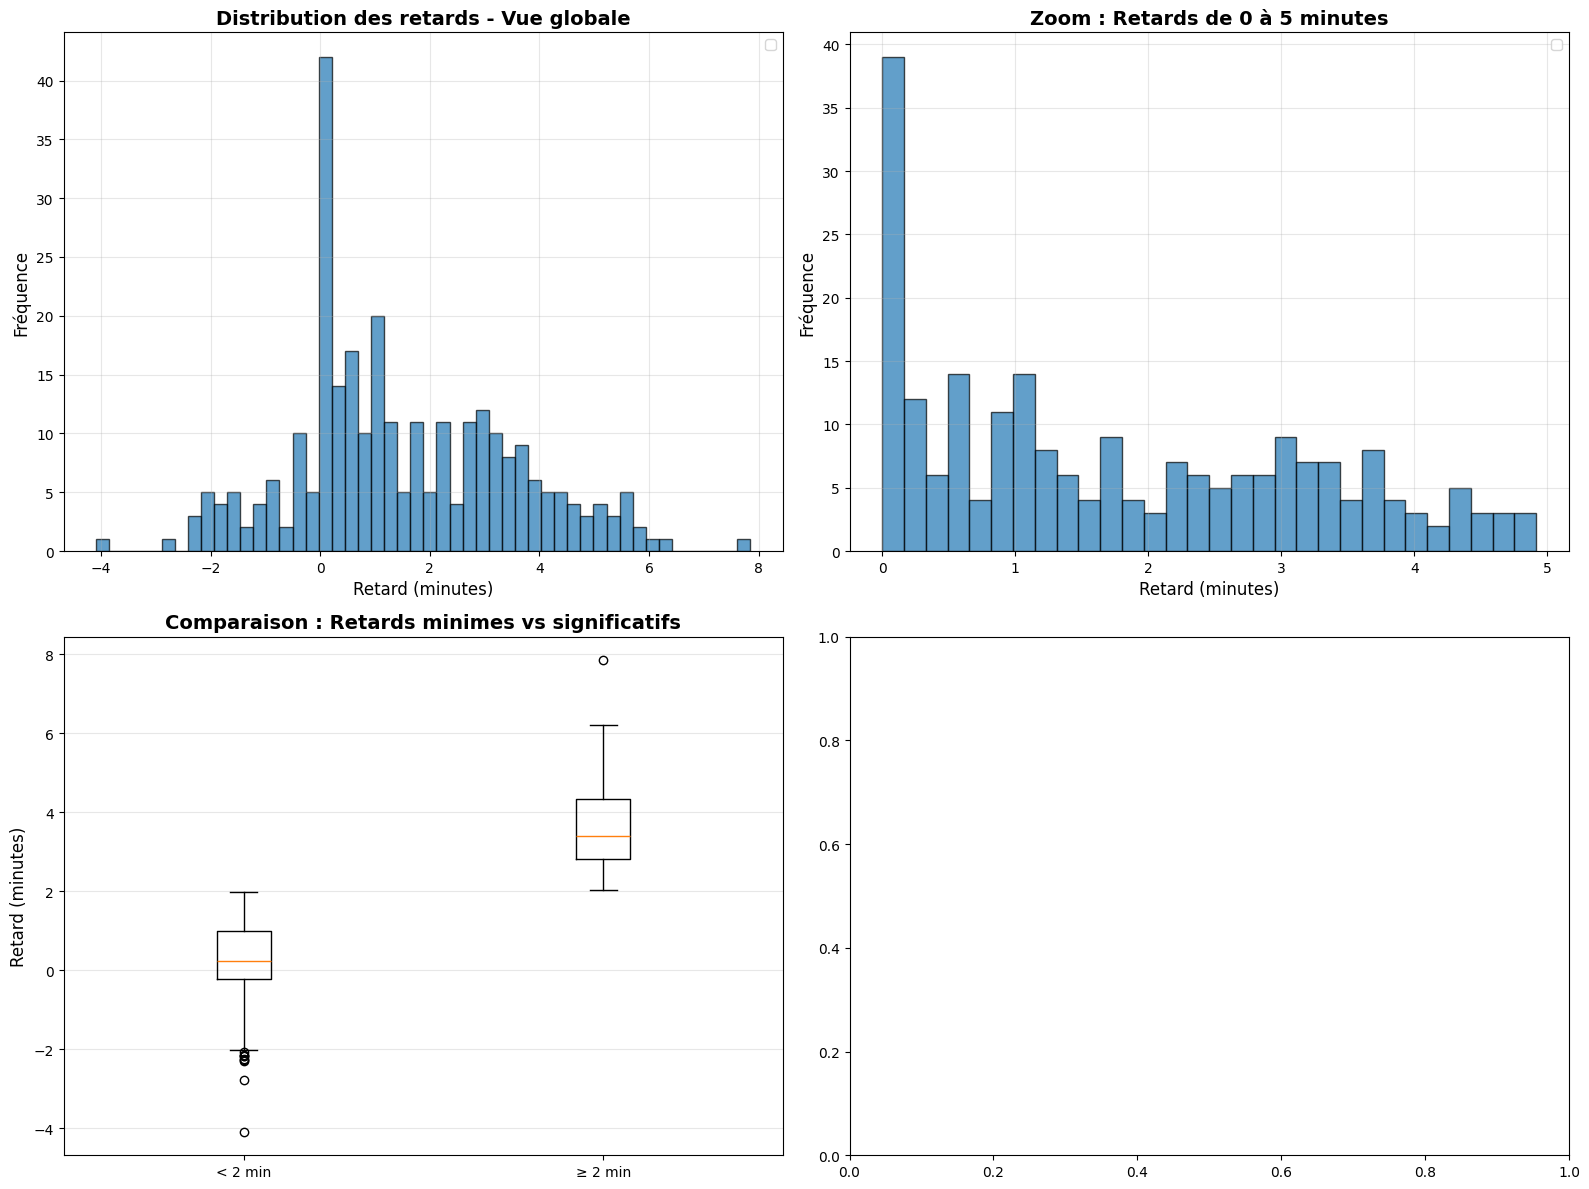

In [84]:
# ====================
# 2. DISTRIBUTION DES RETARDS - ARGUMENT CLÉ
# ====================

print("\n" + "="*20)
print("1. DISTRIBUTION DES RETARDS")
print("="*20)

# Statistiques descriptives
print("\nStatistiques des retards (en secondes) :")
print(df['departure_delay'].describe())
print(f"\nMédiane : {df['departure_delay'].median():.1f}s")
print(f"Mode : {df['departure_delay'].mode().values[0]:.1f}s")

# Conversion en minutes pour lisibilité
df['delay_minutes'] = df['departure_delay'] / 60

# Distribution détaillée par tranches
print("\nRépartition par tranches de retard :")
bins = [-500, 0, 60, 120, 300, 600, 3000]
labels = ['Avance', '0-1 min', '1-2 min', '2-5 min', '5-10 min', '>10 min']
df['delay_category'] = pd.cut(df['departure_delay'], bins=bins, labels=labels)
print(df['delay_category'].value_counts().sort_index())
print("\nEn pourcentage :")
print((df['delay_category'].value_counts(normalize=True)*100).sort_index().round(1))

# GRAPHIQUE 1 : Distribution bimodale
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogramme global
axes[0, 0].hist(df['delay_minutes'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Retard (minutes)', fontsize=12)
axes[0, 0].set_ylabel('Fréquence', fontsize=12)
axes[0, 0].set_title('Distribution des retards - Vue globale', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Focus sur les petits retards (0-5 min)
mask_small = (df['delay_minutes'] >= 0) & (df['delay_minutes'] <= 5)
axes[0, 1].hist(df.loc[mask_small, 'delay_minutes'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Retard (minutes)', fontsize=12)
axes[0, 1].set_ylabel('Fréquence', fontsize=12)
axes[0, 1].set_title('Zoom : Retards de 0 à 5 minutes', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Boxplot par catégories
df_boxplot = df[df['delay_minutes'] <= 20]  # Limiter pour visibilité
axes[1, 0].boxplot([df_boxplot[df_boxplot['delay_minutes'] < 2]['delay_minutes'],
                     df_boxplot[df_boxplot['delay_minutes'] >= 2]['delay_minutes']],
                    labels=['< 2 min', '≥ 2 min'])
axes[1, 0].set_ylabel('Retard (minutes)', fontsize=12)
axes[1, 0].set_title('Comparaison : Retards minimes vs significatifs', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

plt.tight_layout()

On pourrait considérer 2 populations :
- retards minimes vs significatifs
- 68 % des cas, moins de 2 min de rtards (quasi à l'heure)
- 32 % avec plus de 2 min de retards (retards réel)


3. CORRÉLATIONS DIFFÉRENTES SELON LE GROUPE

 Corrélations avec departure_delay :
                Sans_retard_significatif  Avec_retard_significatif  Différence
temperature_2m                     0.118                     0.330       0.211
precipitation                      0.062                     0.187       0.125
wind_speed_10m                     0.150                     0.227       0.077
cloud_cover                        0.054                     0.213       0.159
stop_sequence                     -0.303                    -0.096       0.207
hour                               0.063                    -0.034      -0.096


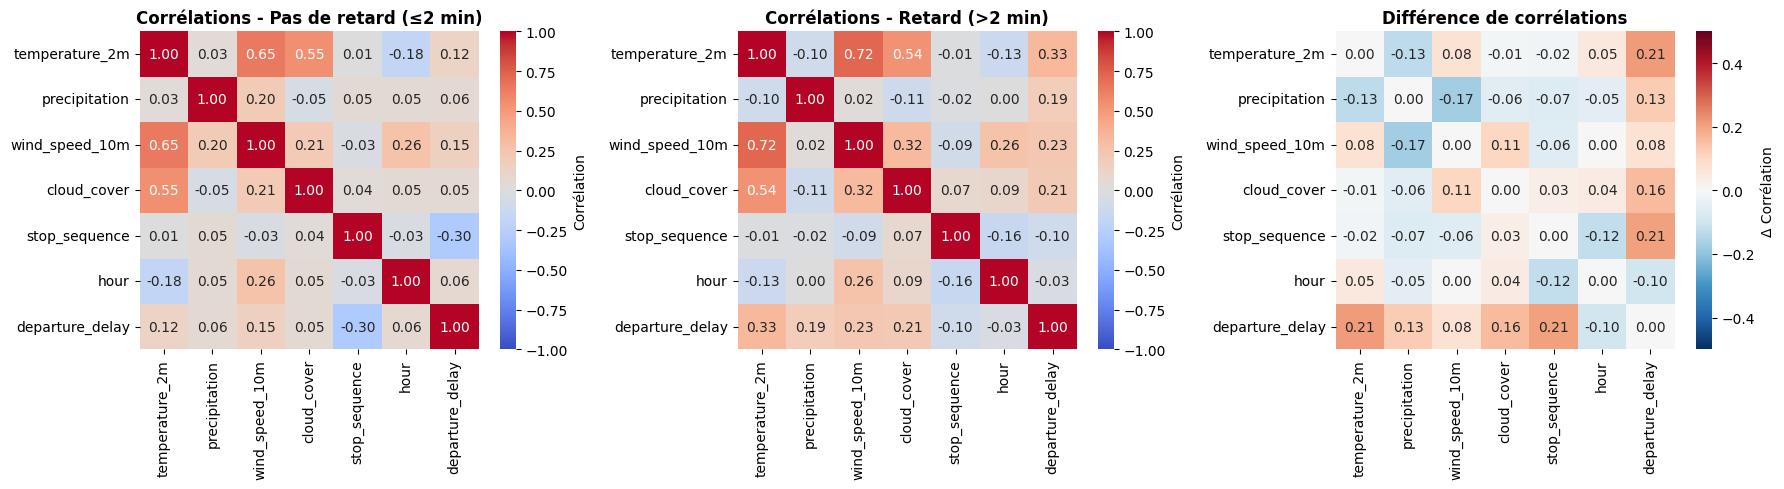

In [85]:
# ============================================================================
# 3. CORRÉLATIONS CONDITIONNELLES
# ============================================================================

print("\n" + "="*20)
print("3. CORRÉLATIONS DIFFÉRENTES SELON LE GROUPE")
print("="*20)

SEUIL = 120  # 2 minutes
df['has_delay'] = (df['departure_delay'] > SEUIL).astype(int)

# Calculer corrélations pour chaque groupe
numeric_cols = ['temperature_2m', 'precipitation', 'wind_speed_10m', 
                'cloud_cover', 'stop_sequence', 'hour']

df_no_delay = df[df['has_delay']==0][numeric_cols + ['departure_delay']].copy()
df_delay = df[df['has_delay']==1][numeric_cols + ['departure_delay']].copy()

corr_no_delay = df_no_delay.corr()['departure_delay'].drop('departure_delay')
corr_delay = df_delay.corr()['departure_delay'].drop('departure_delay')

print("\n Corrélations avec departure_delay :")
corr_comparison = pd.DataFrame({
    'Sans_retard_significatif': corr_no_delay,
    'Avec_retard_significatif': corr_delay,
    'Différence': corr_delay - corr_no_delay
})
print(corr_comparison.round(3))

# GRAPHIQUE 3 : Heatmap comparative
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Sans retard
sns.heatmap(df_no_delay.corr(), annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, ax=axes[0], cbar_kws={'label': 'Corrélation'})
axes[0].set_title('Corrélations - Pas de retard (≤2 min)', fontsize=12, fontweight='bold')

# Avec retard
sns.heatmap(df_delay.corr(), annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, ax=axes[1], cbar_kws={'label': 'Corrélation'})
axes[1].set_title('Corrélations - Retard (>2 min)', fontsize=12, fontweight='bold')

# Différence
diff_matrix = df_delay.corr() - df_no_delay.corr()
sns.heatmap(diff_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, vmin=-0.5, vmax=0.5, ax=axes[2], cbar_kws={'label': 'Δ Corrélation'})
axes[2].set_title('Différence de corrélations', fontsize=12, fontweight='bold')

plt.tight_layout()

Facteurs explicatifs différents
* Les corrélations changent selon le groupe retards +/- 2 min



4. PATTERNS TEMPORELS - Justification de features temporelles

Retards par heure de la journée :
    hour  prob_retard  retard_moyen
0      0         0.80        165.60
1      1         0.50         27.25
2      5         0.00         56.40
3      6         0.25         30.25
4      7         0.29         49.00
5      8         0.00        -15.44
6      9         0.22         50.56
7     10         0.00         25.20
8     11         0.00        -15.00
9     12         0.26         98.05
10    13         0.50        114.23
11    14         0.45        142.55
12    15         0.58        138.29
13    16         0.55        142.85
14    17         0.56        135.88
15    18         0.35         62.30
16    19         0.18         43.47
17    20         0.41         74.65
18    21         0.50        108.38
19    22         0.57        139.64
20    23         0.30         64.30


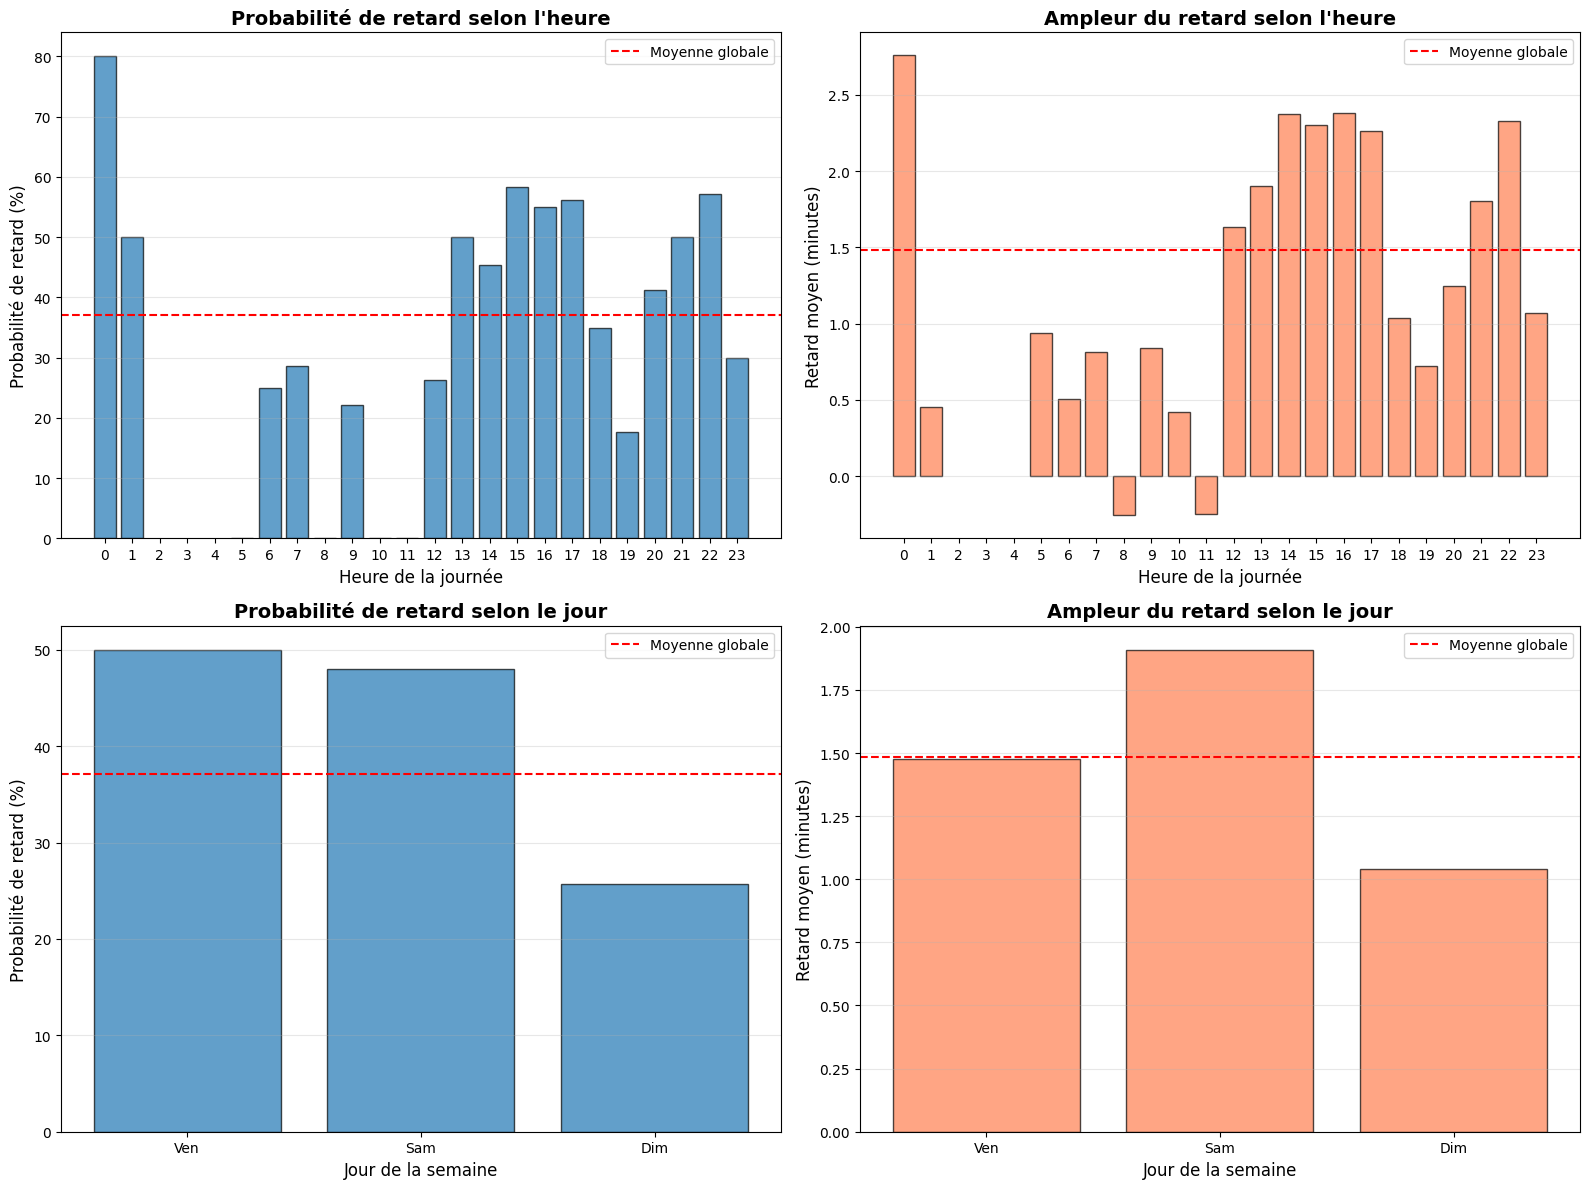

In [86]:
# =====================
# 5. PATTERNS TEMPORELS
# =====================

print("\n" + "="*20)
print("4. PATTERNS TEMPORELS - Justification de features temporelles")
print("="*20)

# Par heure
delay_by_hour = df.groupby('hour').agg({
    'has_delay': 'mean',
    'departure_delay': 'mean'
}).reset_index()
delay_by_hour.columns = ['hour', 'prob_retard', 'retard_moyen']

print("\nRetards par heure de la journée :")
print(delay_by_hour.round(2))

# Par jour de la semaine
delay_by_dow = df.groupby('day_of_week').agg({
    'has_delay': 'mean',
    'departure_delay': 'mean'
}).reset_index()
delay_by_dow.columns = ['day_of_week', 'prob_retard', 'retard_moyen']
delay_by_dow['day_name'] = delay_by_dow['day_of_week'].map({
    0: 'Lun', 1: 'Mar', 2: 'Mer', 3: 'Jeu', 4: 'Ven', 5: 'Sam', 6: 'Dim'
})

# GRAPHIQUE 4 : Patterns temporels
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1- Probabilité de retard par heure
axes[0, 0].bar(delay_by_hour['hour'], delay_by_hour['prob_retard']*100, 
               edgecolor='black', alpha=0.7)
axes[0, 0].axhline(df['has_delay'].mean()*100, color='red', linestyle='--', 
                   label='Moyenne globale')
axes[0, 0].set_xlabel('Heure de la journée', fontsize=12)
axes[0, 0].set_ylabel('Probabilité de retard (%)', fontsize=12)
axes[0, 0].set_title('Probabilité de retard selon l\'heure', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_xticks(range(24))

# 2- Ampleur moyenne par heure
axes[0, 1].bar(delay_by_hour['hour'], delay_by_hour['retard_moyen']/60, 
               color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].axhline(df['departure_delay'].mean()/60, color='red', linestyle='--', 
                   label='Moyenne globale')
axes[0, 1].set_xlabel('Heure de la journée', fontsize=12)
axes[0, 1].set_ylabel('Retard moyen (minutes)', fontsize=12)
axes[0, 1].set_title('Ampleur du retard selon l\'heure', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_xticks(range(24))

# 3- Par jour de la semaine - Probabilité
axes[1, 0].bar(delay_by_dow['day_name'], delay_by_dow['prob_retard']*100, 
               edgecolor='black', alpha=0.7)
axes[1, 0].axhline(df['has_delay'].mean()*100, color='red', linestyle='--', 
                   label='Moyenne globale')
axes[1, 0].set_xlabel('Jour de la semaine', fontsize=12)
axes[1, 0].set_ylabel('Probabilité de retard (%)', fontsize=12)
axes[1, 0].set_title('Probabilité de retard selon le jour', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4- Par jour de la semaine - Ampleur
axes[1, 1].bar(delay_by_dow['day_name'], delay_by_dow['retard_moyen']/60, 
               color='coral', edgecolor='black', alpha=0.7)
axes[1, 1].axhline(df['departure_delay'].mean()/60, color='red', linestyle='--', 
                   label='Moyenne globale')
axes[1, 1].set_xlabel('Jour de la semaine', fontsize=12)
axes[1, 1].set_ylabel('Retard moyen (minutes)', fontsize=12)
axes[1, 1].set_title('Ampleur du retard selon le jour', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()


5. IMPACT MÉTÉO - Différent selon qu'il y a retard ou non

 Retards selon les conditions météo :
              Nombre  Prob_retard  Retard_moyen_sec  Retard_moyen_min
weather_code                                                         
Ciel clair        96         0.25             49.03          0.817167
Neige             25         0.32            102.68          1.711333
Nuageux          167         0.45            109.92          1.832000


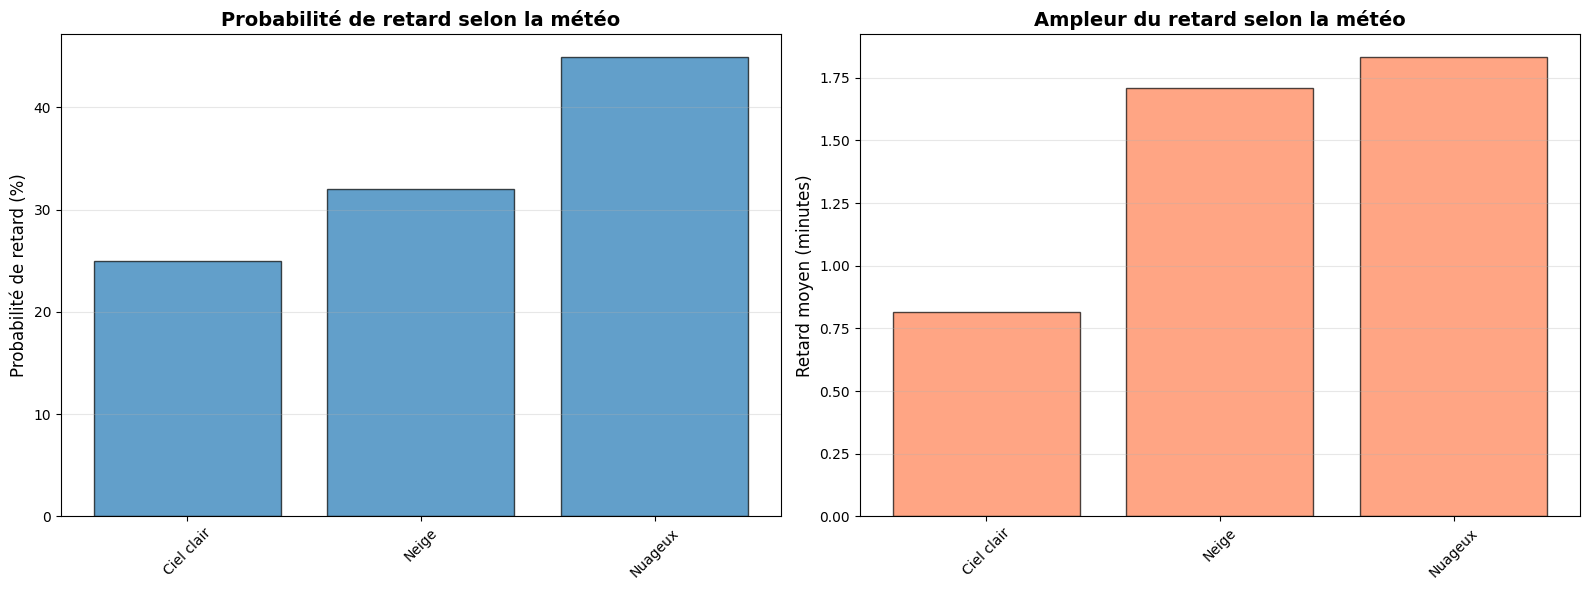

In [87]:
# ========================================
# 6. IMPACT MÉTÉO - VISION CONDITIONNELLE
# =======================================

print("\n" + "="*20)
print("5. IMPACT MÉTÉO - Différent selon qu'il y a retard ou non")
print("="*20)

# Catégoriser la météo
df.loc[df['weather_code'].isin([61, 63, 65]), 'weather_code'] = 'Pluie'
df.loc[df['weather_code'].isin([71, 73, 75]), 'weather_code'] = 'Neige'
df.loc[df['weather_code'].isin([51, 53, 55]), 'weather_code'] = 'Bruine'
df.loc[df['weather_code'].isin([1, 2, 3]), 'weather_code'] = 'Nuageux'
df.loc[df['weather_code'].isin([0]), 'weather_code'] = 'Ciel clair'

print("\n Retards selon les conditions météo :")
meteo_impact = df.groupby('weather_code').agg({
    'has_delay': ['count', 'mean'],
    'departure_delay': 'mean'
}).round(2)

meteo_impact.columns = ['Nombre', 'Prob_retard', 'Retard_moyen_sec']
meteo_impact['Retard_moyen_min'] = meteo_impact['Retard_moyen_sec'] / 60
print(meteo_impact)

# GRAPHIQUE 5 : Impact météo
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

meteo_stats = df.groupby('weather_code').agg({
    'has_delay': 'mean',
    'departure_delay': 'mean'
}).reset_index()

axes[0].bar(meteo_stats['weather_code'], meteo_stats['has_delay']*100, 
            edgecolor='black', alpha=0.7)
axes[0].set_ylabel('Probabilité de retard (%)', fontsize=12)
axes[0].set_title('Probabilité de retard selon la météo', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(meteo_stats['weather_code'], meteo_stats['departure_delay']/60, 
            color='coral', edgecolor='black', alpha=0.7)
axes[1].set_ylabel('Retard moyen (minutes)', fontsize=12)
axes[1].set_title('Ampleur du retard selon la météo', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()

In [88]:
# Statistiques finales
print("\n Statistiques finales :")
print(f"  Nombre total d'observations : {len(df):}")
print(f"  Retard moyen global : {df['departure_delay'].mean()/60:.2f} minutes")
print(f"  Retard moyen si retard >2 min : {df[df['has_delay']==1]['departure_delay'].mean()/60:.2f} minutes")
print(f"  Écart-type global : {df['departure_delay'].std()/60:.2f} minutes")
print(f"  Écart-type si retard >2 min : {df[df['has_delay']==1]['departure_delay'].std()/60:.2f} minutes")

print("\n" + "="*20)
print("EXPLORATION TERMINÉE")
print("="*20)


 Statistiques finales :
  Nombre total d'observations : 288
  Retard moyen global : 1.48 minutes
  Retard moyen si retard >2 min : 3.66 minutes
  Écart-type global : 2.00 minutes
  Écart-type si retard >2 min : 1.14 minutes

EXPLORATION TERMINÉE


## Synthèse 

On pourrait considérer 2 populations :
- retards minimes vs significatifs
- 68 % des cas, moins de 2 min de rtards (quasi à l'heure)
- 32 % avec plus de 2 min de retards (retards réel)

Facteurs explicatifs différents
* Les corrélations changent selon le groupe retards +/- 2 min
* Probabilité de retard vs ampleur du retard différentes

Objectifs différents
* 1/ doit je prévenir l'usager d'un retard ? --> 0/1
* 2/ de combien sera le retard ? --> indication précise
--> prédire 2 min quand il n'y a pas de retard == est-ce utile ??

L'idée
- 1 modèle unique = risque de mélanger deux phénomènes différents
- Regression seule = force à prédire des micro-variations non pertinentes
- deux modèles optimisés : chacun sa tâche

--> Etape 1 : Classfier (retard oui/non avec seuil à 2min)
--> Etape 2 : Si retard prédit, estimer l'ampleur (régression sur uniquement les cas de retards)

# ML

In [89]:
# ====================
# PRÉPARATION DES DONNÉES
# ====================
# Filtrer uniquement les lignes où on a des données de transport
df = df_merged[df_merged['departure_delay'].notna()].copy()

print(f"Nombre total d'observations : {len(df)}")
print(f"Retards > 2 min : {(df['departure_delay'] > 120).sum()} ({(df['departure_delay'] > 120).mean()*100:.1f}%)")



Nombre total d'observations : 288
Retards > 2 min : 107 (37.2%)


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   arrival_delay       288 non-null    int64         
 1   bus_nbr             288 non-null    object        
 2   departure_delay     288 non-null    int64         
 3   direction_id        288 non-null    int64         
 4   hour                288 non-null    int64         
 5   stop_sequence       288 non-null    int64         
 6   timestamp_rounded   288 non-null    datetime64[ns]
 7   cloud_cover         288 non-null    int64         
 8   day_of_week         288 non-null    int64         
 9   dew_point_2m        288 non-null    float64       
 10  est_jour_ferie      288 non-null    int64         
 11  est_weekend         288 non-null    int64         
 12  month               288 non-null    int64         
 13  neige_fondue        288 non-null    int64         

In [91]:
# ====================
# FEATURE ENGINEERING
# ====================

# Définir le seuil de retard (2 minutes = 120 secondes)
SEUIL_RETARD = 120
df['is_delayed'] = (df['departure_delay'] > SEUIL_RETARD).astype(int)

# Features temporelles additionnelles
#df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)

# Sélection des features
feature_cols = [
    # Transport
    'direction_id', 'stop_sequence', 'hour', 
    # Temporel
    'day_of_week', 'est_weekend', 'est_jour_ferie', 'vacances_scolaires',
    'is_rush_hour', 'soleil_leve', 'month',
    # Météo brute
    'temperature_2m', 'precipitation', 'wind_speed_10m', 'cloud_cover',
    'snowfall', 'rain', 'weather_code', 'dew_point_2m', 'wind_direction_10m', 'wind_gusts_10m',
    # Risques
    'risque_gel_neige', 'risque_gel_pluie', 'neige_fondue'
]

# Garder seulement les colonnes existantes
feature_cols = [col for col in feature_cols if col in df.columns]

# Séparer features numériques et catégorielles
numeric_features = df[feature_cols].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df[feature_cols].select_dtypes(include=['object']).columns.tolist()

print(f"\nFeatures numériques : {len(numeric_features)}")
print(f"Features catégorielles : {len(categorical_features)}")


Features numériques : 22
Features catégorielles : 0


In [92]:
# ====================
# PRÉPARATION X ET Y
# ====================

X = df[feature_cols].copy()
y_classification = df['is_delayed']
y_regression = df['departure_delay']

# Split train/test
X_train, X_test, y_class_train, y_class_test = train_test_split(
    X, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

_, _, y_reg_train, y_reg_test = train_test_split(
    X, y_regression, test_size=0.2, random_state=42, stratify=y_classification
)

# ====================
# PIPELINE DE PRÉTRAITEMENT
# ====================

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)


MODÈLE 1 : CLASSIFICATION - Détection de retard > 2 minutes

Entraînement Logistic Regression...
Entraînement Random Forest...
Entraînement XGBoost...

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.62      0.56      0.59        36
           1       0.38      0.45      0.42        22

    accuracy                           0.52        58
   macro avg       0.50      0.51      0.50        58
weighted avg       0.53      0.52      0.52        58

ROC-AUC : 0.482

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.69      0.86      0.77        36
           1       0.62      0.36      0.46        22

    accuracy                           0.67        58
   macro avg       0.65      0.61      0.61        58
weighted avg       0.66      0.67      0.65        58

ROC-AUC : 0.742

--- XGBoost ---
              precision    recall  f1-score   support

           0       0.67      0.83     

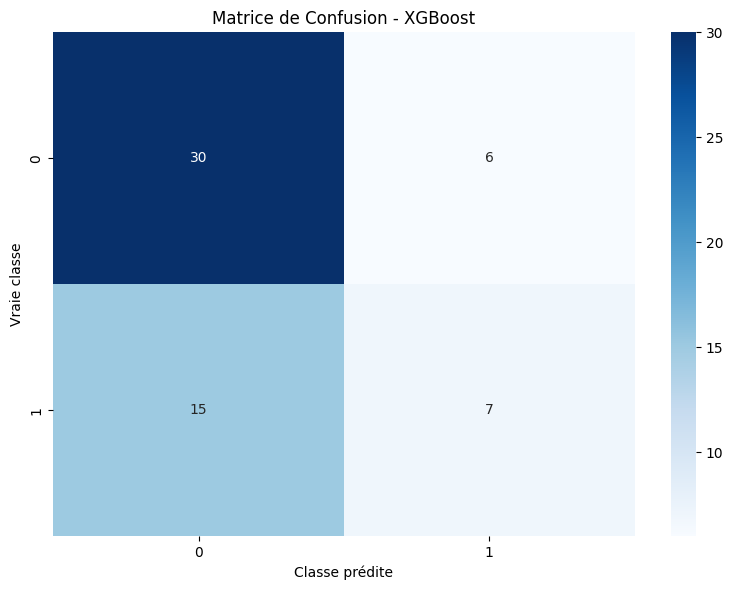

In [96]:
# ====================
# MODÈLE 1 : CLASSIFICATION (Y aura-t-il un retard ?)
# ====================

print("\n" + "="*20)
print("MODÈLE 1 : CLASSIFICATION - Détection de retard > 2 minutes")
print("="*20)

# Modèle 1 : Régression Logistique (simple, interprétable)
clf_logistic = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

# Modèle 2 : Random Forest (plus puissant)
clf_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        class_weight='balanced'
    ))
])

# Modèle 3 : XGBoost 
clf_xgboost = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        eval_metric="logloss", 
        random_state=42,
        scale_pos_weight=(len(y_class_train) - sum(y_class_train)) / sum(y_class_train) # Équivalent de balanced
    ))
])

# Entraîner les deux
print("\nEntraînement Logistic Regression...")
clf_logistic.fit(X_train, y_class_train)
y_pred_log = clf_logistic.predict(X_test)
y_proba_log = clf_logistic.predict_proba(X_test)[:, 1]

print("Entraînement Random Forest...")
clf_rf.fit(X_train, y_class_train)
y_pred_rf = clf_rf.predict(X_test)
y_proba_rf = clf_rf.predict_proba(X_test)[:, 1]

print("Entraînement XGBoost...")
clf_xgboost.fit(X_train, y_class_train)
y_pred_xgboost = clf_xgboost.predict(X_test)
y_proba_xgboost = clf_xgboost.predict_proba(X_test)[:, 1]

# Évaluation
print("\n--- Logistic Regression ---")
print(classification_report(y_class_test, y_pred_log))
print(f"ROC-AUC : {roc_auc_score(y_class_test, y_proba_log):.3f}")

print("\n--- Random Forest ---")
print(classification_report(y_class_test, y_pred_rf))
print(f"ROC-AUC : {roc_auc_score(y_class_test, y_proba_rf):.3f}")

print("\n--- XGBoost ---")
print(classification_report(y_class_test, y_pred_xgboost))
print(f"ROC-AUC : {roc_auc_score(y_class_test, y_proba_xgboost):.3f}")

# Matrice de confusion pour le meilleur modèle (XGBoost)
cm = confusion_matrix(y_class_test, y_pred_xgboost)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion - XGBoost')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.tight_layout()


MODÈLE 2 : RÉGRESSION - Prédiction de l'ampleur du retard

Nombre d'exemples pour la régression :
  Train : 85
  Test : 22

Entraînement Ridge Regression...
Entraînement Random Forest Regressor...

--- Ridge Regression ---
MAE : 58.40 secondes
RMSE : 66.24 secondes
R² : -0.191
MAE : 0.97 minutes

--- Random Forest Regressor ---
MAE : 51.61 secondes
RMSE : 61.87 secondes
R² : -0.040
MAE : 0.86 minutes

IMPORTANCE DES FEATURES


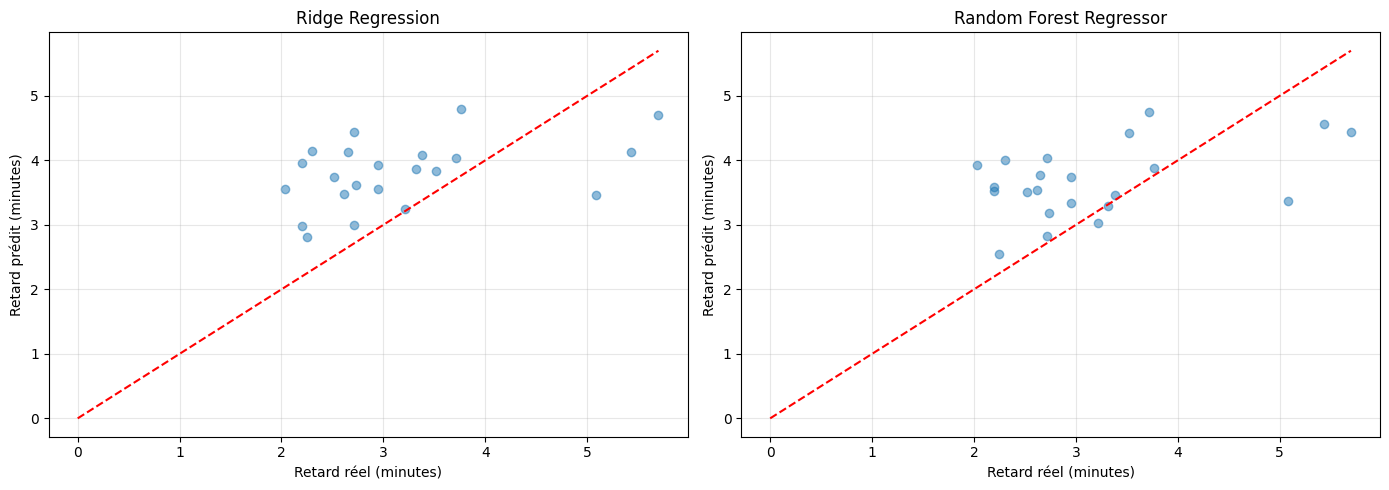

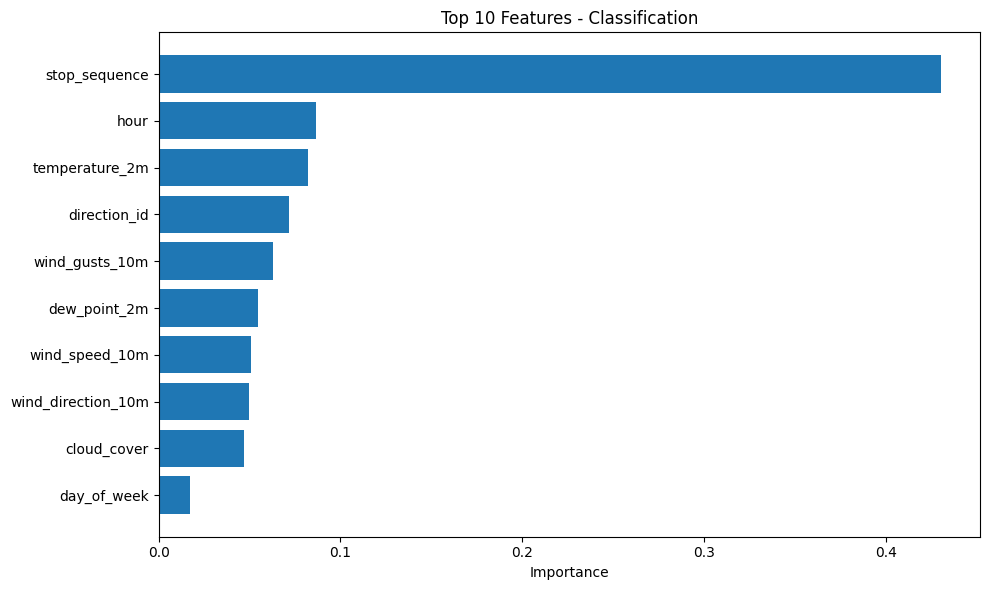

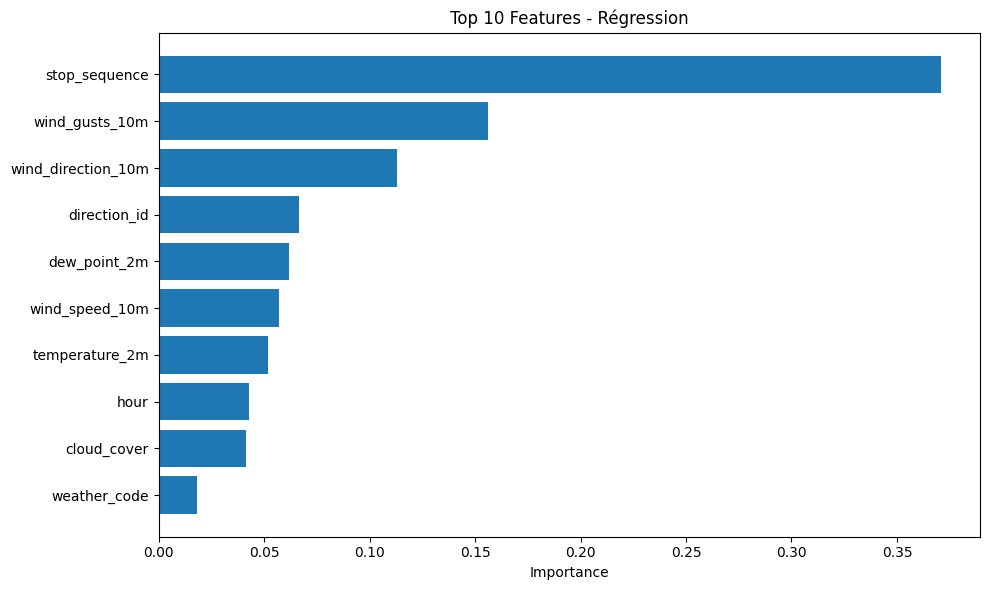

In [97]:
# ====================
# MODÈLE 2 : RÉGRESSION (De combien sera le retard ?)
# ====================

print("\n" + "="*20)
print("MODÈLE 2 : RÉGRESSION - Prédiction de l'ampleur du retard")
print("="*20)

# Filtrer uniquement les cas avec retard pour l'entraînement
mask_train_delayed = y_class_train == 1
mask_test_delayed = y_class_test == 1

X_train_delayed = X_train[mask_train_delayed]
y_reg_train_delayed = y_reg_train[mask_train_delayed]
X_test_delayed = X_test[mask_test_delayed]
y_reg_test_delayed = y_reg_test[mask_test_delayed]

print(f"\nNombre d'exemples pour la régression :")
print(f"  Train : {len(X_train_delayed)}")
print(f"  Test : {len(X_test_delayed)}")

# Modèle 1 : Ridge Regression
reg_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

# Modèle 2 : Random Forest Regressor
reg_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42
    ))
])

# Entraîner les deux
print("\nEntraînement Ridge Regression...")
reg_ridge.fit(X_train_delayed, y_reg_train_delayed)
y_pred_ridge = reg_ridge.predict(X_test_delayed)

print("Entraînement Random Forest Regressor...")
reg_rf.fit(X_train_delayed, y_reg_train_delayed)
y_pred_rf_reg = reg_rf.predict(X_test_delayed)

# Évaluation
def eval_regression(y_true, y_pred, model_name):
    print(f"\n--- {model_name} ---")
    print(f"MAE : {mean_absolute_error(y_true, y_pred):.2f} secondes")
    print(f"RMSE : {np.sqrt(mean_squared_error(y_true, y_pred)):.2f} secondes")
    print(f"R² : {r2_score(y_true, y_pred):.3f}")
    
    # Erreur en minutes
    mae_min = mean_absolute_error(y_true, y_pred) / 60
    print(f"MAE : {mae_min:.2f} minutes")

eval_regression(y_reg_test_delayed, y_pred_ridge, "Ridge Regression")
eval_regression(y_reg_test_delayed, y_pred_rf_reg, "Random Forest Regressor")

# Visualisation des prédictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_reg_test_delayed/60, y_pred_ridge/60, alpha=0.5)
axes[0].plot([0, y_reg_test_delayed.max()/60], [0, y_reg_test_delayed.max()/60], 'r--')
axes[0].set_xlabel('Retard réel (minutes)')
axes[0].set_ylabel('Retard prédit (minutes)')
axes[0].set_title('Ridge Regression')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_reg_test_delayed/60, y_pred_rf_reg/60, alpha=0.5)
axes[1].plot([0, y_reg_test_delayed.max()/60], [0, y_reg_test_delayed.max()/60], 'r--')
axes[1].set_xlabel('Retard réel (minutes)')
axes[1].set_ylabel('Retard prédit (minutes)')
axes[1].set_title('Random Forest Regressor')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

# ====================
# IMPORTANCE DES FEATURES (Random Forest)
# ====================

print("\n" + "="*20)
print("IMPORTANCE DES FEATURES")
print("="*20)

# Pour le classificateur
feature_names_transformed = (
    numeric_features  
    #list(clf_rf.named_steps['preprocessor']
         #.named_transformers_['cat']
         #.get_feature_names_out(categorical_features))
)

importances_clf = clf_rf.named_steps['classifier'].feature_importances_
indices_clf = np.argsort(importances_clf)[-10:]  # Top 10

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices_clf)), importances_clf[indices_clf])
plt.yticks(range(len(indices_clf)), [feature_names_transformed[i] for i in indices_clf])
plt.xlabel('Importance')
plt.title('Top 10 Features - Classification')
plt.tight_layout()

# Pour le régresseur
importances_reg = reg_rf.named_steps['regressor'].feature_importances_
indices_reg = np.argsort(importances_reg)[-10:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices_reg)), importances_reg[indices_reg])
plt.yticks(range(len(indices_reg)), [feature_names_transformed[i] for i in indices_reg])
plt.xlabel('Importance')
plt.title('Top 10 Features - Régression')
plt.tight_layout()

In [98]:
# ====================
# PRÉDICTION EN DEUX ÉTAPES
# ====================

print("\n" + "="*20)
print("EXEMPLE D'UTILISATION - Prédiction en 2 étapes")
print("="*20)

def predict_delay(model_clf, model_reg, X_new):
    """
    Prédit d'abord s'il y aura un retard, puis son ampleur
    """
    # Étape 1 : Classification
    proba_delay = model_clf.predict_proba(X_new)[:, 1]
    has_delay = model_clf.predict(X_new)
    
    # Étape 2 : Régression (seulement si retard prédit)
    delay_amount = np.zeros(len(X_new))
    mask_delayed = has_delay == 1
    
    if mask_delayed.sum() > 0:
        delay_amount[mask_delayed] = model_reg.predict(X_new[mask_delayed])
    
    return has_delay, proba_delay, delay_amount

# Test sur quelques exemples
sample_indices = np.random.choice(len(X_test), 5, replace=False)
X_sample = X_test.iloc[sample_indices]

has_delay, proba, amount = predict_delay(clf_rf, reg_rf, X_sample)

print("\nExemples de prédictions :")
for i, idx in enumerate(sample_indices):
    print(f"\nObservation {i+1}:")
    print(f"  Probabilité de retard : {proba[i]*100:.1f}%")
    if has_delay[i]:
        print(f"  Retard prédit : {amount[i]/60:.1f} minutes")
    else:
        print(f"  Pas de retard prévu")
    print(f"  Retard réel : {y_reg_test.iloc[idx]/60:.1f} minutes")

print("\n" + "="*20)
print("ANALYSE TERMINÉE")
print("="*20)


EXEMPLE D'UTILISATION - Prédiction en 2 étapes

Exemples de prédictions :

Observation 1:
  Probabilité de retard : 44.0%
  Pas de retard prévu
  Retard réel : 1.6 minutes

Observation 2:
  Probabilité de retard : 46.6%
  Pas de retard prévu
  Retard réel : 3.4 minutes

Observation 3:
  Probabilité de retard : 10.8%
  Pas de retard prévu
  Retard réel : -0.4 minutes

Observation 4:
  Probabilité de retard : 50.1%
  Retard prédit : 3.2 minutes
  Retard réel : 2.7 minutes

Observation 5:
  Probabilité de retard : 46.8%
  Pas de retard prévu
  Retard réel : -2.3 minutes

ANALYSE TERMINÉE
